In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [9]:
# Leitura do arquivo Excel
df = pd.read_excel(r'files/input/PROJETO - BASE UNICA (GPT) - 2025.xlsx', sheet_name='Base_Online_2025')

In [10]:
# Informações gerais do DataFrame
print("Informações do DataFrame:")
print(df.info())

print("\nPrimeiras 5 linhas:")
print(df.head())

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DATA                       6149 non-null   datetime64[ns]
 1   PERÍODO                    6103 non-null   object        
 2   AGENTE                     6162 non-null   object        
 3   PERFIL                     6162 non-null   object        
 4   PERSON ID                  6150 non-null   object        
 5   SID DA TAREFA              0 non-null      float64       
 6   NOME DO CLIENTE            6148 non-null   object        
 7   PERGUNTA                   5456 non-null   object        
 8   RESPOSTA                   5341 non-null   object        
 9   PRODUTO                    6156 non-null   object        
 10  ANALISTA                   6290 non-null   object        
 11  CLASSIFICAÇÃO              6133 non-null   

In [11]:
# Estatísticas descritivas
print("Estatísticas descritivas:")
print(df.describe())

# Verificar valores nulos
print("\nValores nulos por coluna:")
print(df.isnull().sum())

Estatísticas descritivas:
                                DATA  SID DA TAREFA  AUDITADO?  \
count                           6149            0.0        0.0   
mean   2025-01-16 05:57:59.112193536            NaN        NaN   
min              2025-01-02 00:00:00            NaN        NaN   
25%    2025-01-09 11:17:20.567000064            NaN        NaN   
50%    2025-01-16 12:10:39.033999872            NaN        NaN   
75%    2025-01-22 11:05:01.313999872            NaN        NaN   
max       2025-01-28 15:33:13.034000            NaN        NaN   
std                              NaN            NaN        NaN   

       DATA AUDITORIA  CONFORMIDADE  
count             0.0           0.0  
mean              NaN           NaN  
min               NaN           NaN  
25%               NaN           NaN  
50%               NaN           NaN  
75%               NaN           NaN  
max               NaN           NaN  
std               NaN           NaN  

Valores nulos por coluna:
DATA      

In [12]:
# Convertendo a coluna DATA para datetime
df['DATA'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')

# Inicializando contadores
total_registros = len(df)
contagem_twilio = 0
contagem_gpt = 0
contagem_gpt_muito_ruim = 0
contagem_gpt_ruim = 0
contagem_perguntas_vazias = 0

# Definindo o período de 2 semanas a partir de 20/01/2025
data_inicial = pd.to_datetime('01/01/2025', format='%d/%m/%Y')
data_final = data_inicial + pd.Timedelta(days=19)

# Filtro para selecionar registros dentro do período de 2 semanas
df_data = df[(df['DATA'] >= data_inicial) & (df['DATA'] <= data_final)].copy()

# Contando perguntas vazias antes de removê-las
contagem_perguntas_vazias = df_data['PERGUNTA'].isna().sum()

# Removendo registros Twilio e perguntas vazias
df_filtrado = df_data[
    (df_data['ORIGEM DO ERRO'] != 'Twilio') & 
    (df_data['PERGUNTA'].notna()) &  # Remove linhas com perguntas vazias
    (df_data['PERGUNTA'].str.strip() != '')  # Remove linhas com perguntas que só tem espaços
].copy()

# Contagens
contagem_twilio = len(df_data[df_data['ORIGEM DO ERRO'] == 'Twilio'])
contagem_gpt = len(df_filtrado[df_filtrado['ORIGEM DO ERRO'] == 'GPT'])
contagem_gpt_muito_ruim = len(df_filtrado[
    (df_filtrado['ORIGEM DO ERRO'] == 'GPT') & 
    (df_filtrado['CLASSIFICAÇÃO'] == '1. Muito ruim')
])
contagem_gpt_ruim = len(df_filtrado[
    (df_filtrado['ORIGEM DO ERRO'] == 'GPT') & 
    (df_filtrado['CLASSIFICAÇÃO'] == '2. Ruim')
])

# Relatório inicial de processamento
print("\nRelatório Inicial de Processamento:")
print(f"Total de registros na data selecionada: {len(df_data)}")
print(f"Registros ignorados (Twilio): {contagem_twilio}")
print(f"Registros com perguntas vazias: {contagem_perguntas_vazias}")
print(f"Registros com erro GPT: {contagem_gpt}")
if contagem_gpt > 0:
    print(f"- Classificados como 'Muito ruim': {contagem_gpt_muito_ruim}")
    print(f"- Classificados como 'Ruim': {contagem_gpt_ruim}")
print(f"Registros válidos para processamento: {len(df_filtrado)}")

# Selecionando apenas as colunas necessárias para o processamento posterior
df_filtrado = df_filtrado[['DATA', 'PERSON ID', 'NOME DO CLIENTE', 'PERGUNTA','CLASSIFICAÇÃO']]

# A partir daqui continua seu código existente...
# Certificando-se de que a coluna 'DATA' está no formato datetime
df_filtrado['DATA'] = pd.to_datetime(df_filtrado['DATA'], errors='coerce')

# Visualizando o resultado
print("\nPrimeiros registros:")
display(df_filtrado.head())


Relatório Inicial de Processamento:
Total de registros na data selecionada: 3536
Registros ignorados (Twilio): 149
Registros com perguntas vazias: 399
Registros com erro GPT: 518
- Classificados como 'Muito ruim': 285
- Classificados como 'Ruim': 230
Registros válidos para processamento: 3037

Primeiros registros:


,DATA,PERSON ID,NOME DO CLIENTE,PERGUNTA,CLASSIFICAÇÃO
0,2025-01-02 09:12:31.477,16248364,THIAGO OLIVEIRA DOS SANTOS\n,Eu começou processo para antecipar o meu FGTS ...,4. Bom
1,2025-01-02 09:12:31.477,7282938,SILVIO DONIZETI DE ABREU\n,Sai hoje ?,4. Bom
2,2025-01-02 09:39:58.781,15977261,MYKELVE COSTA SILVA\n,Eu quero cancelar o meu contrato\n,4. Bom
3,2025-01-02 09:53:12.119,11948661,ALISON LEONCIO DUARTE CASTRO\n,Quero quitas saque aniversário como faço\n,4. Bom
4,2025-01-02 09:56:34.516,12199237,DAIANA DOS SANTOS SOUZA\n,Gostaria de ver se consigo quitar\n,4. Bom


In [13]:
# Função para extrair e formatar o primeiro nome
def formatar_primeiro_nome(nome):
    # Pega o primeiro nome da string e remove espaços extras
    primeiro_nome = nome.split()[0].strip()
    # Converte para a primeira letra maiúscula e resto minúsculo
    return primeiro_nome.capitalize()

# Aplicando a transformação na coluna NOME DO CLIENTE
df_filtrado['NOME DO CLIENTE'] = df_filtrado['NOME DO CLIENTE'].astype(str)  # Converte para string
df_filtrado['NOME DO CLIENTE'] = df_filtrado['NOME DO CLIENTE'].apply(formatar_primeiro_nome)
df_filtrado['DATA'] = pd.to_datetime(df_filtrado['DATA']).dt.date
# Visualizando o resultado
print("Primeiros registros com nomes transformados:")
display(df_filtrado.head())

Primeiros registros com nomes transformados:


,DATA,PERSON ID,NOME DO CLIENTE,PERGUNTA,CLASSIFICAÇÃO
0,2025-01-02,16248364,Thiago,Eu começou processo para antecipar o meu FGTS ...,4. Bom
1,2025-01-02,7282938,Silvio,Sai hoje ?,4. Bom
2,2025-01-02,15977261,Mykelve,Eu quero cancelar o meu contrato\n,4. Bom
3,2025-01-02,11948661,Alison,Quero quitas saque aniversário como faço\n,4. Bom
4,2025-01-02,12199237,Daiana,Gostaria de ver se consigo quitar\n,4. Bom


In [14]:
# Configuração da conexão com PostgreSQL
DB_NAME='mt-genai-api'
DB_USER='mt-genai-api'
DB_PASSWORD='HjkuTHkRMT0CW7Ru3ReE3cbm44lUXzpi'
DB_HOST='tudoinfra.cwljhrdspp7m.us-east-1.rds.amazonaws.com'
DB_PORT=5432

# Criar string de conexão
conn_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Criar engine do SQLAlchemy
engine = create_engine(conn_string)

# Testar conexão
try:
    with engine.connect() as conn:
        print("✅ Conexão estabelecida com sucesso!")
except Exception as e:
    print(f"❌ Erro ao conectar: {e}")

✅ Conexão estabelecida com sucesso!


In [15]:
# Obtendo as datas únicas para consulta otimizada ao banco
datas_unicas = df_filtrado["DATA"].unique()
query = f"""
    SELECT * FROM gpt_api_logs
    WHERE DATE(data_atendimento) IN ({','.join(["'{}'".format(d) for d in datas_unicas])})
"""
df_banco = pd.read_sql(query, engine)

# Ajustando a coluna data_atendimento para ignorar horário
df_banco["data_atendimento"] = pd.to_datetime(df_banco["data_atendimento"]).dt.date

# Garantindo que todas as colunas do banco existam no df_filtrado
for col in df_banco.columns:
    if col not in df_filtrado.columns:
        df_filtrado[col] = None  # Adiciona coluna vazia se não existir

# Iterando sobre cada linha do df_filtrado para buscar correspondência no banco
for index, row in df_filtrado.iterrows():
    filtro_banco = df_banco[
        (df_banco["data_atendimento"] == row["DATA"]) &  # Comparando DATA
        (df_banco["person_id"].astype(str) == str(row["PERSON ID"])) &  # Comparando PERSON ID
        (df_banco["pergunta"].astype(str).str.strip().str.lower() == str(row["PERGUNTA"]).strip().lower())  # Comparando PERGUNTA
    ]
    
    # Verifica se encontrou correspondência e se o nome do cliente bate
    if not filtro_banco.empty:
        match = filtro_banco.iloc[0]  # Pegamos o primeiro resultado caso tenha múltiplos
        if str(match["nome_cliente"]).strip().lower() == str(row["NOME DO CLIENTE"]).strip().lower():
            # Atualiza dinamicamente todas as colunas do df_filtrado com os valores correspondentes do banco
            for col in df_banco.columns:
                df_filtrado.at[index, col] = match[col]

# Exibindo o DataFrame atualizado
display(df_filtrado)

,DATA,PERSON ID,NOME DO CLIENTE,PERGUNTA,CLASSIFICAÇÃO,id,data_atendimento,task_sid,person_id,conversationsid,...,status_contrato,status_esteira_contrato,margin_code,pergunta,resposta_gpt,context_vectordb,fila_twilio,intention,historico_interacoes,usage_tokens
0,2025-01-02,16248364,Thiago,Eu começou processo para antecipar o meu FGTS ...,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2025-01-02,7282938,Silvio,Sai hoje ?,4. Bom,354281,2025-01-02,no value,7282938,CH05fe1b022506491bbb94503e33afb43b,...,no value,FGTS_NEW_PENDING_AUTORIZATION,OK,Sai hoje ?,"Olá, Silvio! 😊\n\nPara que sua antecipação sej...","{'question': ['recebo hoje?', 'FGTS_NEW_PENDIN...",INTERNAL_GPT_FGTS_POS,Pós-Contratação,[{'duvida_cliente': 'Queria saber se meu contr...,1713
2,2025-01-02,15977261,Mykelve,Eu quero cancelar o meu contrato\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2025-01-02,11948661,Alison,Quero quitas saque aniversário como faço\n,4. Bom,354534,2025-01-02,no value,11948661,CH018b7b9590054233a9e73117955adcf9,...,no value,FGTS_NEW_PAID,7,Quero quitas saque aniversário como faço,Olá Alison! 😊\n\nVi que você solicitou uma ant...,{'question': ['Tem como quitar a antecipação d...,INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1225
4,2025-01-02,12199237,Daiana,Gostaria de ver se consigo quitar\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3967,2025-01-20,12213110,Maria,Corrigir dados bancários\n,4. Bom,481492,2025-01-20,no value,12213110,CH469ea548cfa248dc84309f944b50f4a3,...,no value,PAYMENT_RETURNED,None,Corrigir dados bancários,"Oi Maria! 😊\n\nPor determinação do INSS, o pag...","{'question': ['Dados bancários.', 'PAYMENT_RET...",INTERNAL_GPT_INSS_PRE,Pré-Contratação,[],1284
3968,2025-01-20,4997650,Gisele,Quero cancelar\n,4. Bom,481825,2025-01-20,no value,4997650,CHc196818db71245438360a8d1ebd01870,...,no value,WAITING_TO_SEND_TO_BANK,None,Quero cancelar,Fico feliz por ter ajudado. 😊\n\nSe você desej...,"{'question': 'Não quero mais cancelar', 'dista...",INTERNAL_GPT_INSS_PRE,Pré-Contratação,"[{'duvida_cliente': 'Cancela esse contrato', '...",1539
3969,2025-01-20,5278821,Josiana,O dinheiro não caiu pq está errado alguma cois...,1. Muito ruim,481541,2025-01-20,no value,5278821,CHc70bf165c3204df6933c3a984428a92a,...,no value,PAYMENT_RETURNED,None,O dinheiro não caiu pq está errado alguma cois...,Verifiquei o atraso no pagamento da sua propos...,{'question': 'Eu quero saber o que está aconte...,INTERNAL_GPT_INSS_PRE,Pré-Contratação,"[{'duvida_cliente': 'Até agora', 'resposta_gpt...",1612
3970,2025-01-20,3635197,Maria,Esse dinheiro\n,1. Muito ruim,481496,2025-01-20,no value,3635197,CH356813845e914bda80bf5eeef4863ea9,...,no value,PAID,7,Esse dinheiro,"Após a averbação do contrato, Maria, o pagamen...","{'question': 'Quando entra meu dinheiro', 'dis...",INTERNAL_GPT_INSS_PRE,Pré-Contratação,[{'duvida_cliente': 'Mas como faço pra receber...,1464


In [16]:
# Criando um DataFrame com as linhas que NÃO tiveram correspondência no banco
colunas_com_dados = [col for col in df_banco.columns if df_filtrado[col].notna().any()]
df_nao_encontrados = df_filtrado[df_filtrado[colunas_com_dados[0]].isna()]

# Exibir as primeiras linhas sem correspondência para análise
print("\n🔍 Linhas que NÃO tiveram correspondência no banco:")
display(df_nao_encontrados.head(10))

# Contar ocorrências de cada valor nas colunas principais para identificar padrões
print("\n📊 Contagem de valores nas linhas SEM correspondência:")

print("📅 Datas que não foram encontradas:")
print(df_nao_encontrados['DATA'].value_counts())

print("\n🆔 PERSON ID que não foram encontrados:")
print(df_nao_encontrados['PERSON ID'].value_counts())

print("\n👤 Nomes de cliente que não foram encontrados:")
print(df_nao_encontrados['NOME DO CLIENTE'].value_counts())

print("\n❓ Perguntas que não foram encontradas:")
print(df_nao_encontrados['PERGUNTA'].value_counts())

# Salvar essas linhas em um CSV para análise mais detalhada
df_nao_encontrados.to_csv("linhas_sem_correspondencia.csv", index=False)
print("\n📁 As linhas sem correspondência foram salvas no arquivo 'linhas_sem_correspondencia.csv'")



🔍 Linhas que NÃO tiveram correspondência no banco:


,DATA,PERSON ID,NOME DO CLIENTE,PERGUNTA,CLASSIFICAÇÃO,id,data_atendimento,task_sid,person_id,conversationsid,...,status_contrato,status_esteira_contrato,margin_code,pergunta,resposta_gpt,context_vectordb,fila_twilio,intention,historico_interacoes,usage_tokens
0,2025-01-02,16248364,Thiago,Eu começou processo para antecipar o meu FGTS ...,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2025-01-02,15977261,Mykelve,Eu quero cancelar o meu contrato\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2025-01-02,12199237,Daiana,Gostaria de ver se consigo quitar\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,2025-01-02,13318161,Gabriela,Já está no meu cartão da Caixa o valor credita...,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,2025-01-02,9888339,Thiago,Quero cancelar\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
12,2025-01-02,11061577,Genivan,Quero saber quanto é para quitar todo meu cont...,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
15,2025-01-02,15214890,Reveinildo,E posivel quitar\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
17,2025-01-02,12528048,Gabriel,Quero encerrar minha conta\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
19,2025-01-02,13593490,Joao,Falar com um atendente\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
26,2025-01-02,5257435,Maria,Falar com atendente\n,4. Bom,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None



📊 Contagem de valores nas linhas SEM correspondência:
📅 Datas que não foram encontradas:
DATA
2025-01-14    89
2025-01-15    63
2025-01-07    49
2025-01-09    43
2025-01-02    41
2025-01-10    36
2025-01-16    34
2025-01-06    34
2025-01-08    30
2025-01-17    29
2025-01-03    24
2025-01-13    12
2025-01-20     6
Name: count, dtype: int64

🆔 PERSON ID que não foram encontrados:
PERSON ID
16215401    3
3740413     2
13911900    2
13316127    2
16373880    2
           ..
3710016     1
15207788    1
6623923     1
10036908    1
4430563     1
Name: count, Length: 476, dtype: int64

👤 Nomes de cliente que não foram encontrados:
NOME DO CLIENTE
Maria        29
Jose         19
Antonio      11
Ana           9
Lucas         6
             ..
Gerson        1
Marislane     1
Bernardo      1
Sidney        1
Janaina       1
Name: count, Length: 335, dtype: int64

❓ Perguntas que não foram encontradas:
PERGUNTA
Falar com atendente\n                                                                   

In [17]:
import json

# Função para extrair "distances" corretamente, verificando se já é um dicionário
def extrair_distances(texto):
    if pd.isna(texto):  # Se for None ou NaN, retorna lista vazia
        return []
    
    try:
        if isinstance(texto, dict):  # Se já for um dicionário, pega diretamente
            return texto.get("distances", [])
        elif isinstance(texto, str):  # Se for string, tenta converter para JSON
            data = json.loads(texto.replace("'", '"'))  # Corrige aspas se necessário
            return data.get("distances", [])
        else:
            return []
    except (json.JSONDecodeError, TypeError) as e:  
        print(f"Erro ao processar JSON: {texto}\nErro: {e}")  # Depuração para ver erros
        return []  # Retorna lista vazia caso o JSON seja inválido

# Criando a nova coluna apenas para as linhas que têm dados do banco
df_filtrado.loc[df_filtrado[colunas_com_dados[0]].notna(), 'distances_list'] = df_filtrado['context_vectordb'].apply(extrair_distances)

# Filtrando o DataFrame para exibição
df_resultado = df_filtrado[df_filtrado[colunas_com_dados[0]].notna()]

# Exibir os primeiros registros do DataFrame filtrado com a nova coluna
print("\n🔍 Exibindo os registros com correspondência no banco + distances_list:")
display(df_resultado[['context_vectordb', 'distances_list']].head(10))



🔍 Exibindo os registros com correspondência no banco + distances_list:


,context_vectordb,distances_list
1,"{'question': ['recebo hoje?', 'FGTS_NEW_PENDIN...","[0.86026025, 1.0000463]"
3,{'question': ['Tem como quitar a antecipação d...,"[0.9427817, 1.0001062]"
5,{'question': ['O pagamento é realizado ainda h...,"[0.9380255, 1.0001062]"
8,{'question': ['Pq está demorando para deposita...,"[0.8931443, 1.0000463]"
9,{'question': ['Está com a instituição não auto...,"[0.9066607, 1.0000463]"
11,"{'question': ['Como saber se foi aprovado', 'F...","[0.94744617, 1.0001062]"
13,"{'question': ['Já autorizei', 'FGTS_NEW_PENDIN...","[1.0000046, 1.0000463]"
16,"{'question': ['Oi bom dia', 'FGTS_NEW_PENDING_...","[0.92125094, 1.0000463]"
18,{'question': ['Até agora não recebi o valor do...,"[0.92533493, 1.0001062]"
20,{'question': [' Fiz a antecipação sábado e até...,"[0.927981, 1.0000463]"


In [18]:
# Função para transformar a coluna distances_list conforme as regras definidas
def transformar_distances(lista):
    if not isinstance(lista, list) or len(lista) == 0:  # Se não for lista ou for vazia, retorna None
        return None
    if len(lista) >= 1:  # Se tiver um ou mais valores, retorna apenas o primeiro
        return lista[0]

# Aplicando a função diretamente na coluna distances_list
df_filtrado['distances_list'] = df_filtrado['distances_list'].apply(transformar_distances)

# Removendo as linhas onde distances_list contém 0
df_filtrado = df_filtrado[df_filtrado['distances_list'] != 0]

# Filtrando para exibir apenas os registros válidos
df_resultado = df_filtrado[df_filtrado[colunas_com_dados[0]].notna()]

# Exibir os primeiros registros para verificar se a transformação foi aplicada corretamente
print("\n🔍 Exibindo os registros com distances_list transformado:")
display(df_resultado[['context_vectordb', 'distances_list']].head(10))



🔍 Exibindo os registros com distances_list transformado:


,context_vectordb,distances_list
1,"{'question': ['recebo hoje?', 'FGTS_NEW_PENDIN...",0.860260
3,{'question': ['Tem como quitar a antecipação d...,0.942782
5,{'question': ['O pagamento é realizado ainda h...,0.938025
8,{'question': ['Pq está demorando para deposita...,0.893144
9,{'question': ['Está com a instituição não auto...,0.906661
11,"{'question': ['Como saber se foi aprovado', 'F...",0.947446
13,"{'question': ['Já autorizei', 'FGTS_NEW_PENDIN...",1.000005
16,"{'question': ['Oi bom dia', 'FGTS_NEW_PENDING_...",0.921251
18,{'question': ['Até agora não recebi o valor do...,0.925335
20,{'question': [' Fiz a antecipação sábado e até...,0.927981


In [19]:
df_resultado.head(10)

,DATA,PERSON ID,NOME DO CLIENTE,PERGUNTA,CLASSIFICAÇÃO,id,data_atendimento,task_sid,person_id,conversationsid,...,status_esteira_contrato,margin_code,pergunta,resposta_gpt,context_vectordb,fila_twilio,intention,historico_interacoes,usage_tokens,distances_list
1,2025-01-02,7282938,Silvio,Sai hoje ?,4. Bom,354281,2025-01-02,no value,7282938,CH05fe1b022506491bbb94503e33afb43b,...,FGTS_NEW_PENDING_AUTORIZATION,OK,Sai hoje ?,"Olá, Silvio! 😊\n\nPara que sua antecipação sej...","{'question': ['recebo hoje?', 'FGTS_NEW_PENDIN...",INTERNAL_GPT_FGTS_POS,Pós-Contratação,[{'duvida_cliente': 'Queria saber se meu contr...,1713,0.860260
3,2025-01-02,11948661,Alison,Quero quitas saque aniversário como faço\n,4. Bom,354534,2025-01-02,no value,11948661,CH018b7b9590054233a9e73117955adcf9,...,FGTS_NEW_PAID,7,Quero quitas saque aniversário como faço,Olá Alison! 😊\n\nVi que você solicitou uma ant...,{'question': ['Tem como quitar a antecipação d...,INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1225,0.942782
5,2025-01-02,11221966,Driane,O pagamento foi realizado porém o dinheiro não...,4. Bom,354499,2025-01-02,no value,11221966,CH380e36b8b3f149e4b06655914fe893a0,...,FGTS_NEW_PAID,OK,O pagamento foi realizado porém o dinheiro não...,"Olá, Driane! 😊\n\nVi que você solicitou uma an...",{'question': ['O pagamento é realizado ainda h...,INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1070,0.938025
8,2025-01-02,9192252,Cecilia,O banco que eu botei pra fazer o depósito do s...,4. Bom,354584,2025-01-02,no value,9192252,CH8ab3ef72be874150a738d0cb3c551d74,...,FGTS_NEW_PENDING_AUTORIZATION,OK,O banco que eu botei pra fazer o depósito do s...,Olá Cecilia! 😊\n\nPara que possamos concluir a...,{'question': ['Pq está demorando para deposita...,INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1173,0.893144
9,2025-01-02,12905832,Suelen,Oiê eu fiz o contrato...mas vi que tava em ave...,4. Bom,354600,2025-01-02,no value,12905832,CHddf04d01521445c4b59b039c3dced1b0,...,FGTS_NEW_PENDING_AUTORIZATION,OK,Oiê eu fiz o contrato...mas vi que tava em ave...,"Oi Suelen! 😊\n\nPelo que você mencionou, parec...",{'question': ['Está com a instituição não auto...,INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1240,0.906661
11,2025-01-02,16254183,Elizeu,Queria saber si eu fui aprovado\n,4. Bom,355052,2025-01-02,no value,16254183,CH1ea14d5b89b847e181fd06101f787510,...,FGTS_NEW_PAID,OK,Queria saber si eu fui aprovado,Olá Elizeu! 😊\n\nVi que você solicitou uma ant...,"{'question': ['Como saber se foi aprovado', 'F...",INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1096,0.947446
13,2025-01-02,5173725,Claudenilce,Já autorizei\n,4. Bom,355210,2025-01-02,no value,5173725,CHc93d04bcdd3549cab453fdbfca3b56a1,...,FGTS_NEW_PENDING_AUTORIZATION,OK,Já autorizei,"Que ótima notícia, Claudenilce! Agradecemos po...","{'question': ['Já autorizei', 'FGTS_NEW_PENDIN...",INTERNAL_GPT_FGTS_POS,Pós-Contratação,[{'duvida_cliente': 'Bom dia eu já fiz a autor...,1770,1.000005
16,2025-01-02,15422641,Gabriell,Oii Ana bom dia\n,4. Bom,355731,2025-01-02,no value,15422641,CHe02acf9d443b4551800f8421aefe3775,...,FGTS_NEW_PENDING_AUTORIZATION,OK,Oii Ana bom dia,"Olá, Gabriell! Bom dia! ☀️\n\nPara que possamo...","{'question': ['Oi bom dia', 'FGTS_NEW_PENDING_...",INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1101,0.921251
18,2025-01-02,4359864,Roberta,Fiz um saque aniversário com vcs e o valor não...,1. Muito ruim,355691,2025-01-02,no value,4359864,CH6272fececc6b47b8ad8a240d87a0a1e4,...,FGTS_NEW_PAID,OK,Fiz um saque aniversário com vcs e o valor não...,"Olá, Roberta! 😊\n\nVi que você solicitou uma a...",{'question': ['Até agora não recebi o valor do...,INTERNAL_GPT_FGTS_POS,Pós-Contratação,[],1114,0.925335
20,2025-01-02,14513957,Eliane,Fiz uma antecipação dia 31 e até hoje não caiu\n,4. Bom,356104,2025-01-02,no value,14513957,CH726728533e5c45eebb312985e55ca121,...,FGTS_NEW_PENDING_AUTORIZATION,OK,Fiz uma antecipação dia 31 e até hoje não caiu,"Olá, Eliane! 😊\n\nPara que sua antecipação sej...",{'question': [' Fiz a antecipação sábado e até...,INTERNAL_GP

/tmp/ipykernel_12185/3107440770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado['CLASSIFICAÇÃO'] = df_resultado['CLASSIFICAÇÃO'].str.replace(r'^\d+\.\s*', '', regex=True)


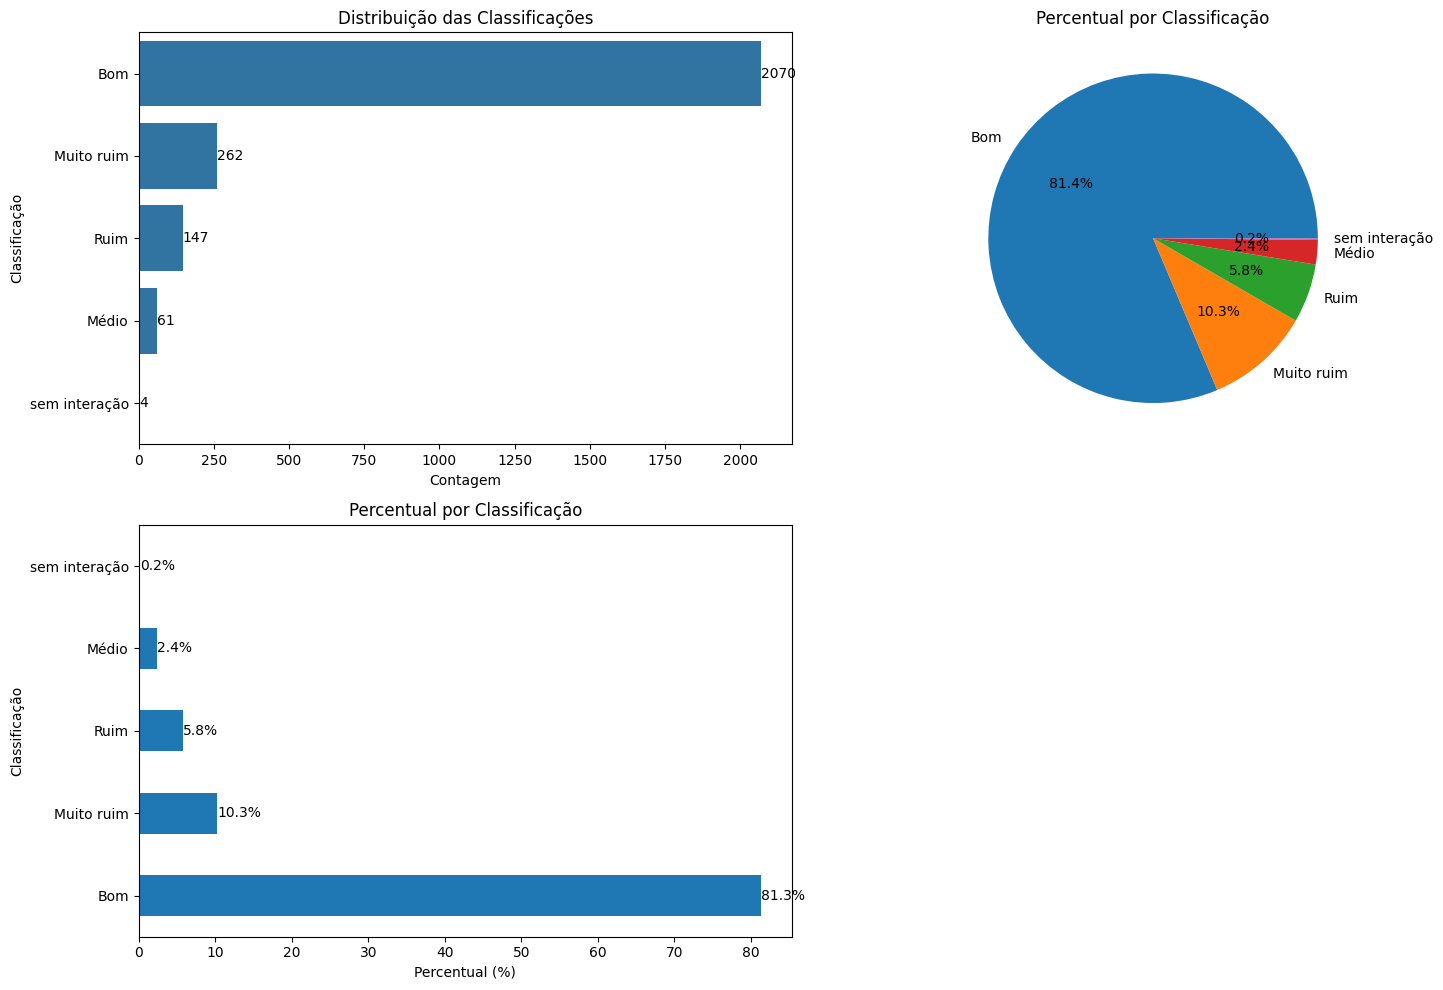


Estatísticas Descritivas:

Contagem por Classificação:
CLASSIFICAÇÃO
Bom              2070
Muito ruim        262
Ruim              147
Médio              61
sem interação       4
Name: count, dtype: int64

Percentual por Classificação:
CLASSIFICAÇÃO
Bom              81.34
Muito ruim       10.29
Ruim              5.78
Médio             2.40
sem interação     0.16
Name: count, dtype: float64 %


In [20]:
# Limpar os números da coluna CLASSIFICAÇÃO
df_resultado['CLASSIFICAÇÃO'] = df_resultado['CLASSIFICAÇÃO'].str.replace(r'^\d+\.\s*', '', regex=True)

# Configurar o tamanho da figura
plt.figure(figsize=(15, 10))

# 1. Gráfico de barras com contagem
plt.subplot(2, 2, 1)
ax = sns.countplot(data=df_resultado, y='CLASSIFICAÇÃO', 
                  order=df_resultado['CLASSIFICAÇÃO'].value_counts().index)
plt.title('Distribuição das Classificações')
plt.xlabel('Contagem')
plt.ylabel('Classificação')

# Adicionar valores nas barras
for i in ax.containers:
    ax.bar_label(i)

# 2. Gráfico de pizza com percentuais
plt.subplot(2, 2, 2)
classificacao_counts = df_resultado['CLASSIFICAÇÃO'].value_counts()
plt.pie(classificacao_counts, labels=classificacao_counts.index, autopct='%1.1f%%')
plt.title('Percentual por Classificação')

# 3. Gráfico de barras horizontais com percentuais
plt.subplot(2, 2, 3)
classificacao_pct = (classificacao_counts / len(df_resultado) * 100)
ax = classificacao_pct.plot(kind='barh')
plt.title('Percentual por Classificação')
plt.xlabel('Percentual (%)')
plt.ylabel('Classificação')

# Adicionar valores nas barras
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%')

# 4. Box plot caso haja alguma variável numérica relacionada
# Substitua 'VALOR' pelo nome da sua coluna numérica, se houver
if 'VALOR' in df_resultado.columns:
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df_resultado, x='CLASSIFICAÇÃO', y='VALOR')
    plt.title('Distribuição de Valores por Classificação')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("\nEstatísticas Descritivas:")
print("\nContagem por Classificação:")
print(classificacao_counts)
print("\nPercentual por Classificação:")
print(classificacao_pct.round(2), "%")

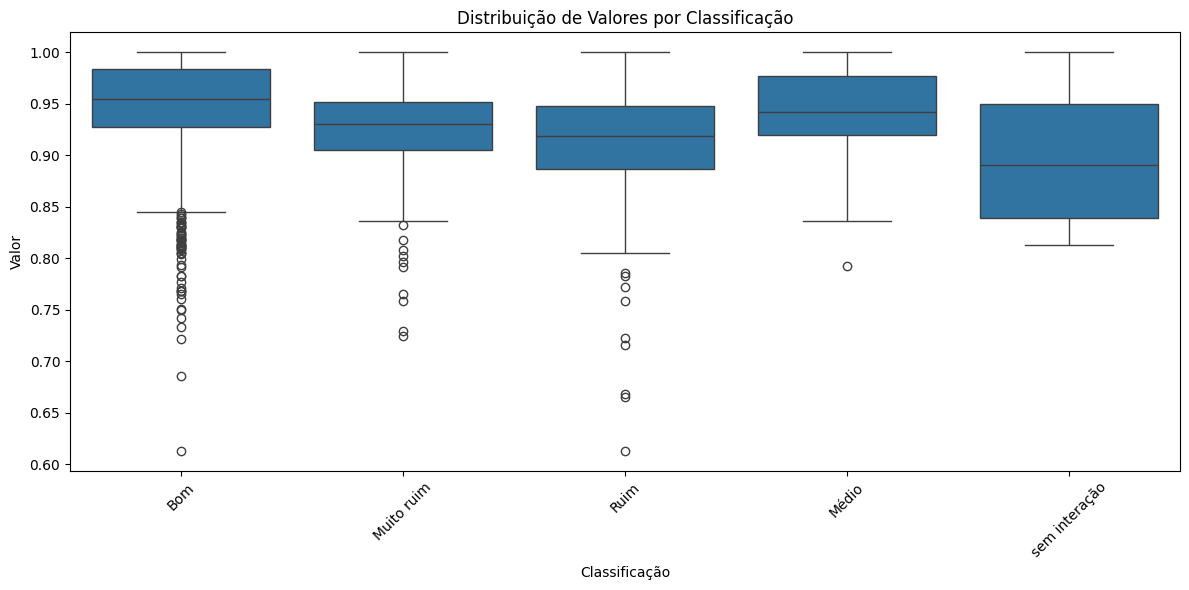

In [21]:
# Configurar o tamanho da figura para o boxplot
plt.figure(figsize=(12, 6))

# Criar o boxplot
sns.boxplot(data=df_resultado, x='CLASSIFICAÇÃO', y='distances_list')

# Configurar o título e labels
plt.title('Distribuição de Valores por Classificação')
plt.xlabel('Classificação')
plt.ylabel('Valor')

# Rotacionar os labels do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [22]:
# Caminho onde o arquivo será salvo
caminho_arquivo = "df_resultado.xlsx"

# Salvando o DataFrame em um arquivo .xlsx
df_resultado.to_excel(caminho_arquivo, index=False)

print(f"Arquivo salvo como {caminho_arquivo}")

Arquivo salvo como df_resultado.xlsx



📊 Resumo Estatístico das Distâncias:
         DATA     Média   Mediana  Percentil_25  Percentil_50  Percentil_75  \
0  2025-01-02  0.946849  0.952836      0.924474      0.952836      0.977352   
1  2025-01-03  0.942891  0.950268      0.918555      0.950268      0.982751   
2  2025-01-06  0.948822  0.951748      0.929289      0.951748      0.977165   
3  2025-01-07  0.942655  0.950496      0.917035      0.950496      0.980207   
4  2025-01-08  0.948313  0.957924      0.925236      0.957924      0.985574   
5  2025-01-09  0.945997  0.948847      0.921431      0.948847      0.982787   
6  2025-01-10  0.941744  0.945772      0.923182      0.945772      0.976300   
7  2025-01-13  0.940013  0.943228      0.918460      0.943228      0.968151   
8  2025-01-14  0.937526  0.946529      0.912952      0.946529      0.973904   
9  2025-01-15  0.942348  0.952884      0.918250      0.952884      0.977380   

     Mínimo    Máximo  
0  0.818139  1.000116  
1  0.613049  1.000122  
2  0.760330  1.00012

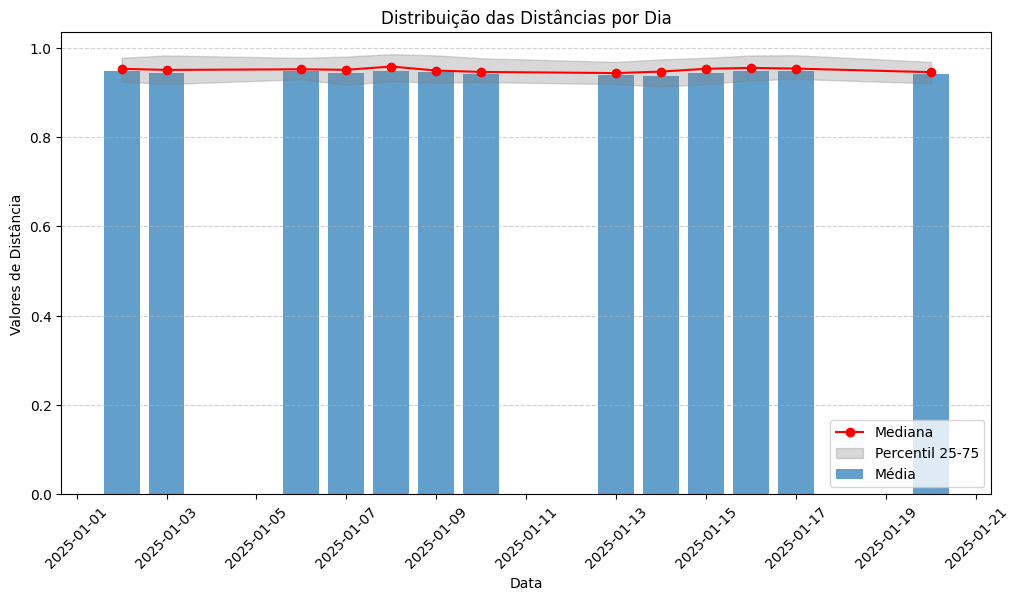

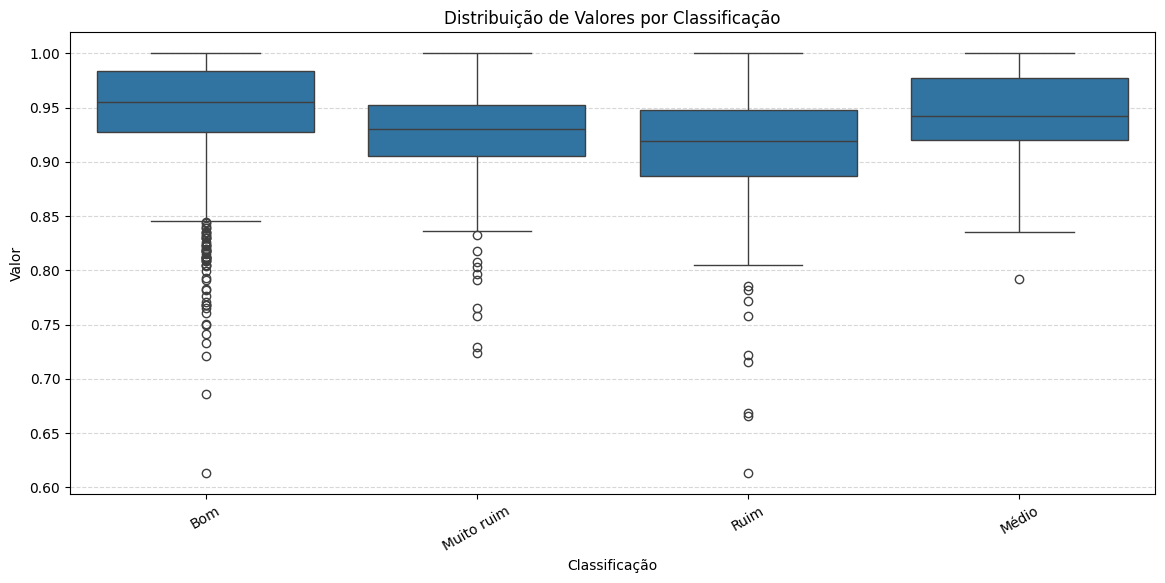

In [23]:
# Filtrar categorias com pelo menos 10 ocorrências para evitar distorção extrema
categorias_significativas = df_resultado["CLASSIFICAÇÃO"].value_counts()
categorias_validas = categorias_significativas[categorias_significativas >= 10].index
df_filtrado = df_resultado[df_resultado["CLASSIFICAÇÃO"].isin(categorias_validas)]

# Criar estatísticas por DATA
df_analise = df_filtrado.groupby("DATA")["distances_list"].agg([
    ("Média", "mean"),
    ("Mediana", "median"),
    ("Percentil_25", lambda x: x.quantile(0.25)),
    ("Percentil_50", lambda x: x.quantile(0.50)),  # Igual à Mediana
    ("Percentil_75", lambda x: x.quantile(0.75)),
    ("Mínimo", "min"),
    ("Máximo", "max")
]).reset_index()

# Exibir estatísticas no Jupyter Notebook
print("\n📊 Resumo Estatístico das Distâncias:")
print(df_analise.head(10))  # Mostra as 10 primeiras linhas da análise

# Salvar para análise posterior (caso necessário)
df_analise.to_csv("resumo_estatistico_distancias.csv", index=False)
print("\n📁 Arquivo 'resumo_estatistico_distancias.csv' salvo com sucesso!")

# Criar gráfico de colunas mostrando a distribuição diária das distâncias
plt.figure(figsize=(12, 6))
plt.bar(df_analise["DATA"], df_analise["Média"], label="Média", alpha=0.7)
plt.plot(df_analise["DATA"], df_analise["Mediana"], marker='o', linestyle='-', color='r', label="Mediana")
plt.fill_between(df_analise["DATA"], df_analise["Percentil_25"], df_analise["Percentil_75"], color='gray', alpha=0.3, label="Percentil 25-75")
plt.xticks(rotation=45)
plt.xlabel("Data")
plt.ylabel("Valores de Distância")
plt.title("Distribuição das Distâncias por Dia")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostrar gráfico
plt.show()

# Criar Boxplot para visualizar a distribuição de distâncias por Classificação
plt.figure(figsize=(14, 6))
sns.boxplot(x="CLASSIFICAÇÃO", y="distances_list", data=df_filtrado)
plt.xlabel("Classificação")
plt.ylabel("Valor")
plt.title("Distribuição de Valores por Classificação")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Mostrar gráfico
plt.show()


📊 Analisando CLASSIFICAÇÃO: Bom
         DATA     Média   Mediana  Percentil_25  Percentil_50  Percentil_75  \
0  2025-01-02  0.949873  0.954150      0.927085      0.954150      0.981683   
1  2025-01-03  0.950941  0.953536      0.926777      0.953536      0.986312   
2  2025-01-06  0.951337  0.953796      0.931583      0.953796      0.977730   
3  2025-01-07  0.948912  0.955859      0.924571      0.955859      0.981179   
4  2025-01-08  0.953515  0.958730      0.930069      0.958730      0.991760   
5  2025-01-09  0.950656  0.955947      0.929374      0.955947      0.986437   
6  2025-01-10  0.950500  0.955198      0.928987      0.955198      0.982712   
7  2025-01-13  0.941752  0.943451      0.920153      0.943451      0.970612   
8  2025-01-14  0.941926  0.951456      0.918171      0.951456      0.977209   
9  2025-01-15  0.948229  0.958303      0.927229      0.958303      0.982160   

     Mínimo    Máximo  
0  0.818139  1.000116  
1  0.808309  1.000109  
2  0.760330  1.000115  
3

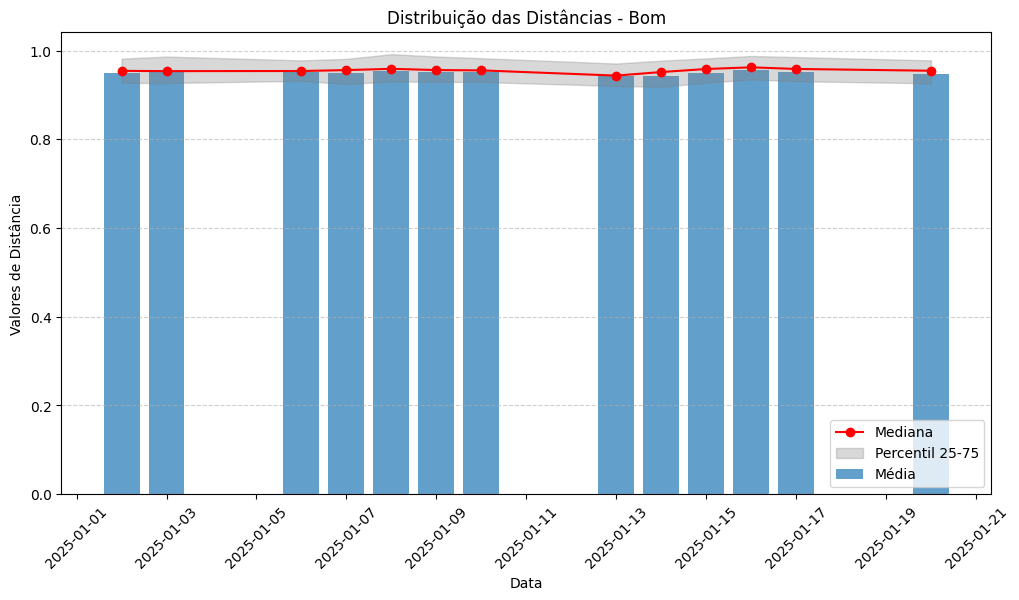

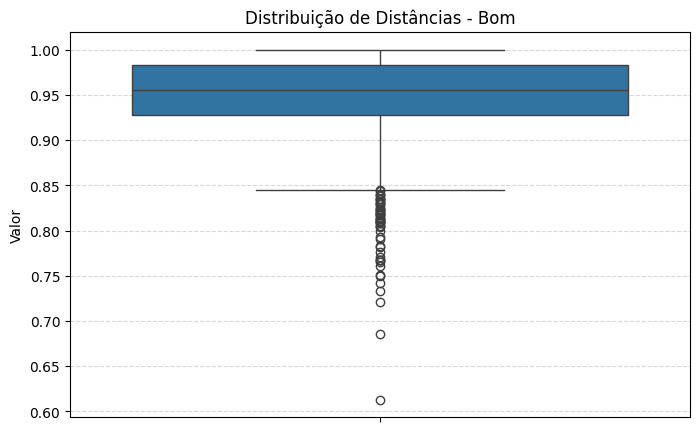


📊 Analisando CLASSIFICAÇÃO: Muito ruim
         DATA     Média   Mediana  Percentil_25  Percentil_50  Percentil_75  \
0  2025-01-02  0.930619  0.942451      0.922259      0.942451      0.957961   
1  2025-01-03  0.920304  0.930130      0.890094      0.930130      0.953293   
2  2025-01-06  0.937720  0.933637      0.925191      0.933637      0.958632   
3  2025-01-07  0.921276  0.922006      0.903074      0.922006      0.949638   
4  2025-01-08  0.930027  0.946385      0.918701      0.946385      0.960153   
5  2025-01-09  0.916954  0.918259      0.904847      0.918259      0.945429   
6  2025-01-10  0.914383  0.928864      0.901222      0.928864      0.943644   
7  2025-01-13  0.923980  0.929872      0.894211      0.929872      0.947482   
8  2025-01-14  0.923086  0.939954      0.907426      0.939954      0.954004   
9  2025-01-15  0.924578  0.928328      0.912962      0.928328      0.949436   

     Mínimo    Máximo  
0  0.859126  0.975398  
1  0.807565  1.000021  
2  0.861047  0.985

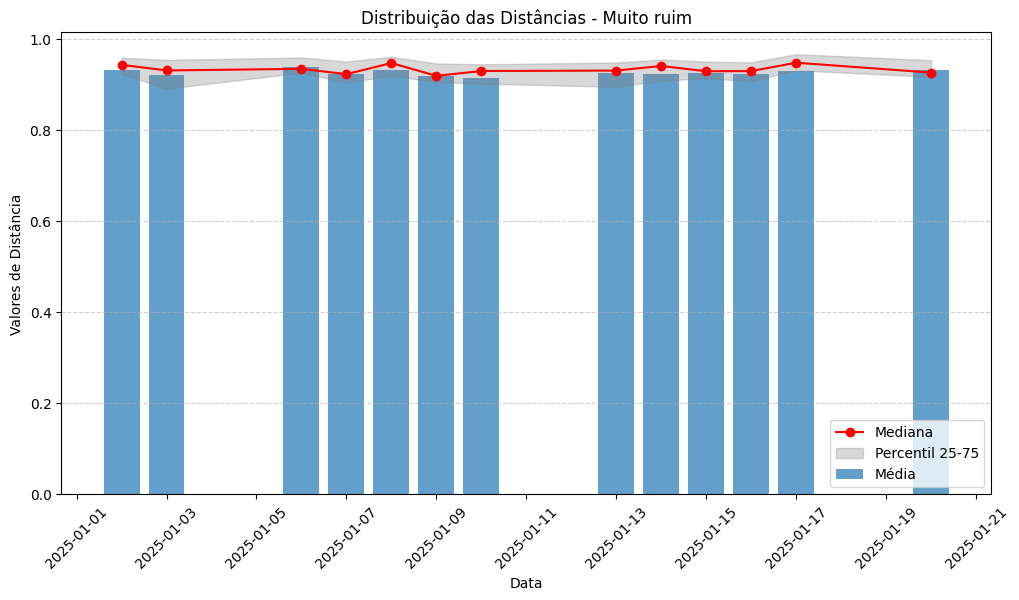

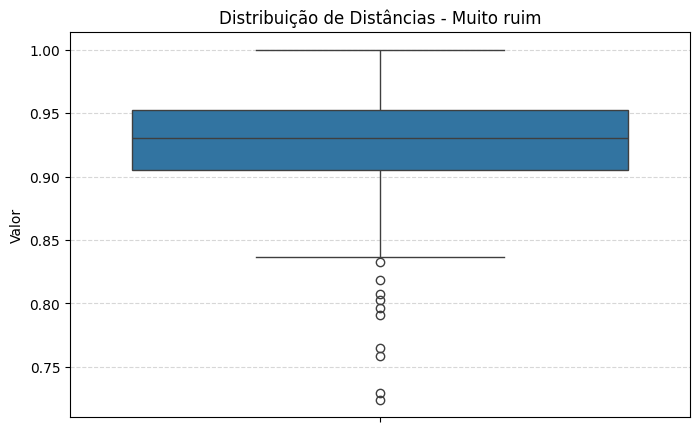


📊 Analisando CLASSIFICAÇÃO: Ruim
         DATA     Média   Mediana  Percentil_25  Percentil_50  Percentil_75  \
0  2025-01-02  0.935409  0.941004      0.917461      0.941004      0.960602   
1  2025-01-03  0.885359  0.904638      0.872164      0.904638      0.941507   
2  2025-01-06  0.936804  0.942037      0.917642      0.942037      0.968373   
3  2025-01-07  0.896950  0.905023      0.894580      0.905023      0.918906   
4  2025-01-08  0.879186  0.910224      0.842437      0.910224      0.939407   
5  2025-01-09  0.913781  0.911250      0.894399      0.911250      0.918863   
6  2025-01-10  0.894912  0.919248      0.888194      0.919248      0.936146   
7  2025-01-13  0.930008  0.937307      0.921366      0.937307      0.942326   
8  2025-01-14  0.895186  0.895114      0.885211      0.895114      0.938783   
9  2025-01-15  0.916250  0.934105      0.881254      0.934105      0.955609   

     Mínimo    Máximo  
0  0.866794  0.979390  
1  0.613049  0.987868  
2  0.829135  1.000122  


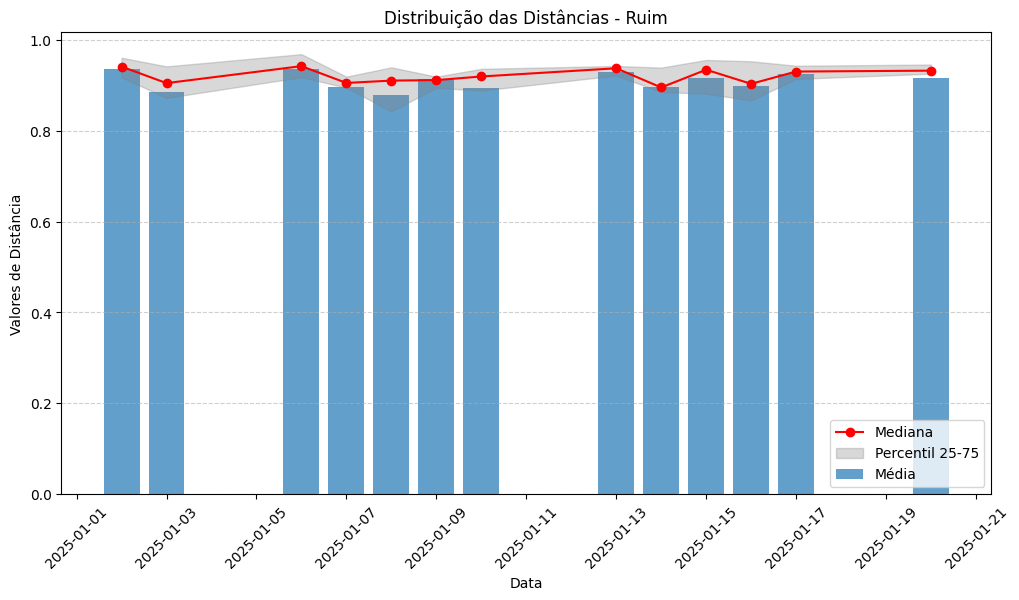

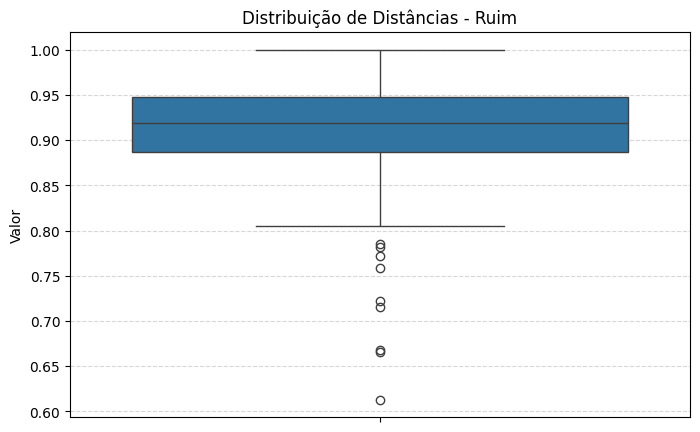


📊 Analisando CLASSIFICAÇÃO: Médio
         DATA     Média   Mediana  Percentil_25  Percentil_50  Percentil_75  \
0  2025-01-02  0.902268  0.902268      0.881935      0.902268      0.922600   
1  2025-01-03  0.951450  0.964700      0.927080      0.964700      0.975888   
2  2025-01-06  0.926357  0.927019      0.915939      0.927019      0.937437   
3  2025-01-07  0.949481  0.977817      0.931920      0.977817      0.983183   
4  2025-01-08  0.971899  0.971899      0.971899      0.971899      0.971899   
5  2025-01-09  0.991037  0.991037      0.986538      0.991037      0.995536   
6  2025-01-10  0.939965  0.944640      0.903523      0.944640      0.975286   
7  2025-01-13  0.959437  0.959437      0.959437      0.959437      0.959437   
8  2025-01-14  0.913011  0.912735      0.889794      0.912735      0.935952   
9  2025-01-15  0.919662  0.942329      0.879857      0.942329      0.973977   

     Mínimo    Máximo  
0  0.861602  0.942933  
1  0.879118  1.000122  
2  0.887226  0.964163  

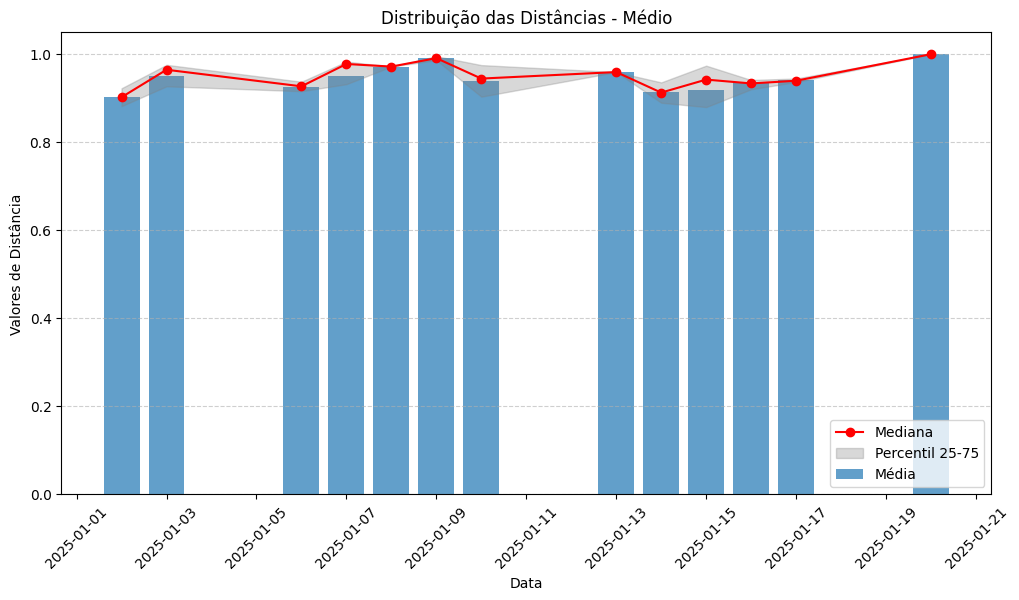

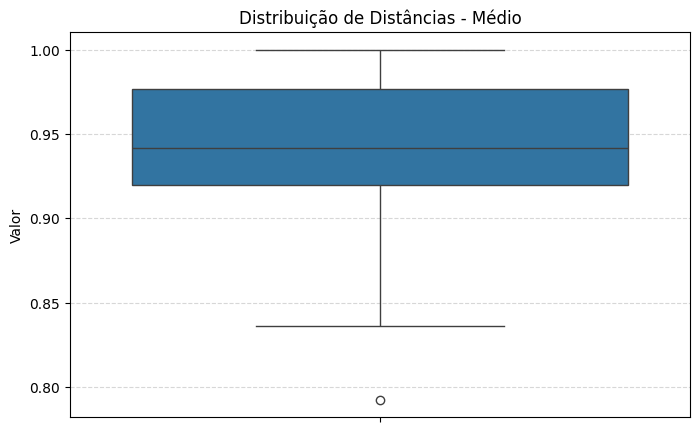


⚠️ Classificação 'sem interação' tem poucos dados (4 registros), então será ignorada.

⚠️ Classificação 'nan' tem poucos dados (0 registros), então será ignorada.


In [24]:
# Obter todas as classificações únicas no dataset
classificacoes_unicas = df_resultado["CLASSIFICAÇÃO"].unique()

# Criar uma análise separada para cada CLASSIFICAÇÃO
for classificacao in classificacoes_unicas:
    # Filtrar apenas os dados da classificação atual
    df_class = df_resultado[df_resultado["CLASSIFICAÇÃO"] == classificacao]
    
    # Verificar se há dados suficientes para análise
    if len(df_class) < 10:
        print(f"\n⚠️ Classificação '{classificacao}' tem poucos dados ({len(df_class)} registros), então será ignorada.")
        continue
    
    print(f"\n📊 Analisando CLASSIFICAÇÃO: {classificacao}")

    # Criar estatísticas por DATA
    df_analise = df_class.groupby("DATA")["distances_list"].agg([
        ("Média", "mean"),
        ("Mediana", "median"),
        ("Percentil_25", lambda x: x.quantile(0.25)),
        ("Percentil_50", lambda x: x.quantile(0.50)),  # Igual à Mediana
        ("Percentil_75", lambda x: x.quantile(0.75)),
        ("Mínimo", "min"),
        ("Máximo", "max")
    ]).reset_index()

    # Exibir resumo estatístico da categoria
    print(df_analise.head(10))  # Mostra as primeiras linhas da análise

    # Criar gráfico de colunas mostrando a distribuição diária das distâncias
    plt.figure(figsize=(12, 6))
    plt.bar(df_analise["DATA"], df_analise["Média"], label="Média", alpha=0.7)
    plt.plot(df_analise["DATA"], df_analise["Mediana"], marker='o', linestyle='-', color='r', label="Mediana")
    plt.fill_between(df_analise["DATA"], df_analise["Percentil_25"], df_analise["Percentil_75"], color='gray', alpha=0.3, label="Percentil 25-75")
    plt.xticks(rotation=45)
    plt.xlabel("Data")
    plt.ylabel("Valores de Distância")
    plt.title(f"Distribuição das Distâncias - {classificacao}")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    
    # Mostrar gráfico
    plt.show()

    # Criar Boxplot para visualizar a distribuição de distâncias dentro da classificação
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=df_class["distances_list"])
    plt.ylabel("Valor")
    plt.title(f"Distribuição de Distâncias - {classificacao}")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Mostrar gráfico
    plt.show()